In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
%matplotlib inline

import matplotlib.pyplot as plt

## Load In the Data

In [2]:
skin_df = pd.read_csv("D:/Smart Healthcare/Skin-Lesions-Detection-Deep-learning-main/Skin-Lesions-Detection-Deep-learning-main/Notebooks/hmnist_64_64_RBG.csv")

In [3]:
skin_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,191,152,194,191,153,195,192,149,192,194,...,185,154,180,186,156,184,182,152,173,2
1,24,13,23,24,14,28,37,24,46,61,...,26,15,29,27,15,28,24,13,25,2
2,185,129,140,192,136,151,198,142,156,198,...,152,120,138,144,113,123,115,81,84,2
3,24,11,19,36,19,30,64,38,50,91,...,27,13,16,25,12,16,24,9,14,2
4,138,94,117,158,113,138,178,133,161,191,...,140,106,118,108,77,92,67,40,55,2


In [4]:
X = skin_df.drop("label", axis=1).values
label = skin_df["label"].values

In [5]:
X.shape, label.shape

((10015, 12288), (10015,))

## Scaling and Split Data into Train, Validation and Test set

In [6]:
X_mean = np.mean(X)
X_std = np.std(X)

X = (X - X_mean)/X_std

In [7]:
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, label, test_size=0.1,random_state=0)

In [8]:
X_train_orig.shape, X_test.shape, y_train_orig.shape, y_test.shape

((9013, 12288), (1002, 12288), (9013,), (1002,))

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.2, random_state=1)

In [10]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7210, 12288), (1803, 12288), (7210,), (1803,))

## Reshape the Data to Input in CNN

In [11]:
X_train = X_train.reshape(X_train.shape[0], *(64, 64, 3))
X_val = X_val.reshape(X_val.shape[0], *(64, 64, 3))
X_test = X_test.reshape(X_test.shape[0], *(64, 64, 3))

In [12]:
X_train.shape, X_val.shape, X_test.shape

((7210, 64, 64, 3), (1803, 64, 64, 3), (1002, 64, 64, 3))

In [13]:
y_train.shape

(7210,)

In [14]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [15]:
y_train.shape, y_val.shape, y_test.shape

((7210, 7), (1803, 7), (1002, 7))

## CNN Model

In [16]:
# Our input feature map is 64x64x3: 64x64 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(64, 64, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model
model = Model(img_input, output)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

C:\Users\91987\anaconda3\envs\tensor\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496 

## Define Data Generator for Data Augmentation and Learning Rate Adaptive Reduction to Prevent Overfitting

In [18]:
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [20]:
batch_size = 64
epochs = 30
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

C:\Users\91987\AppData\Local\Temp\ipykernel_13996\3666111815.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/30
112/112 [==============================] - 11s 57ms/step - loss: 0.9836 - accuracy: 0.6560 - val_loss: 0.8900 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 2/30
112/112 [==============================] - 6s 55ms/step - loss: 0.8613 - accuracy: 0.6886 - val_loss: 0.8160 - val_accuracy: 0.7022 - lr: 0.0010
Epoch 3/30
112/112 [==============================] - 6s 55ms/step - loss: 0.8042 - accuracy: 0.7032 - val_loss: 0.7946 - val_accuracy: 0.7005 - lr: 0.0010
Epoch 4/30
112/112 [==============================] - 6s 55ms/step - loss: 0.7735 - accuracy: 0.7092 - val_loss: 0.7521 - val_accuracy: 0.7338 - lr: 0.0010
Epoch 5/30
112/112 [==============================] - 6s 54ms/step - loss: 0.7524 - accuracy: 0.7166 - val_loss: 0.7294 - val_accuracy: 0.7260 - lr: 0.0010
Epoch 6/30
112/112 [==============================] - 6s 55ms/step - loss: 0.7540 - accuracy: 0.7158 - val_loss: 0.7269 - val_accuracy: 0.7343 - lr: 0.0010
Epoch 7/30
112/112 [==============================] - 6s 55ms/s

112/112 [==============================] - 6s 54ms/step - loss: 0.6203 - accuracy: 0.7697 - val_loss: 0.6315 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 22/30
112/112 [==============================] - 6s 54ms/step - loss: 0.6259 - accuracy: 0.7624 - val_loss: 0.6548 - val_accuracy: 0.7554 - lr: 0.0010
Epoch 23/30
112/112 [==============================] - 6s 54ms/step - loss: 0.6066 - accuracy: 0.7706 - val_loss: 0.6402 - val_accuracy: 0.7587 - lr: 0.0010
Epoch 24/30
112/112 [==============================] - 6s 54ms/step - loss: 0.5961 - accuracy: 0.7762 - val_loss: 0.6960 - val_accuracy: 0.7454 - lr: 0.0010
Epoch 25/30
112/112 [==============================] - 6s 54ms/step - loss: 0.5933 - accuracy: 0.7786 - val_loss: 0.6465 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 26/30
112/112 [==============================] - 6s 54ms/step - loss: 0.5895 - accuracy: 0.7820 - val_loss: 0.6292 - val_accuracy: 0.7615 - lr: 0.0010
Epoch 27/30
112/112 [==============================] - 6s 54ms/step - 

In [21]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))
model.save("D:/Smart Healthcare/Skin-Lesions-Detection-Deep-learning-main/Skin-Lesions-Detection-Deep-learning-main/Saved Models/Base.h5")

57/57 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.7643
Validation: accuracy = 0.764282  ;  loss_v = 0.623189
Test: accuracy = 0.758483  ;  loss = 0.664846


Text(0.5, 1.0, 'Training and validation loss')

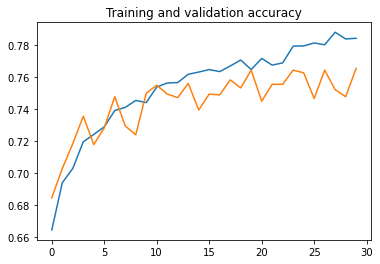

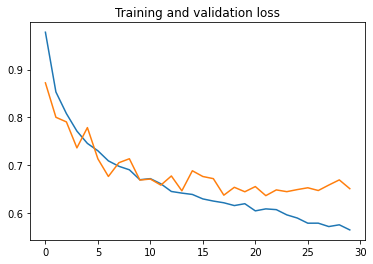

In [25]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')